# Product Review Sentiment Analysis

This notebook analyzes customer sentiment from product reviews to identify common themes, positive feedback, and pain points. The steps include data loading, text preprocessing, sentiment analysis, exploratory data analysis, topic modeling, and insight generation.

## Objectives
- Load and explore the product review dataset
- Clean and preprocess review text
- Perform sentiment analysis (TextBlob)
- Visualize sentiment distributions and word clouds
- Analyze sentiment trends by product and time
- Discover topics in negative reviews (LDA)
- Summarize actionable insights

In [18]:
# Install required libraries if needed (uncomment if running in a fresh environment)
# !pip install pandas numpy matplotlib seaborn wordcloud scikit-learn nltk textblob

In [19]:
import nltk

# Download required NLTK data (run this only once)
# Download only if not already present
def safe_nltk_download(resource):
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(resource.split('/')[-1])

safe_nltk_download('tokenizers/punkt')
safe_nltk_download('corpora/stopwords')
safe_nltk_download('corpora/wordnet')
nltk.download('omw-1.4')  # Optional for lemmatizer support

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OceanComputers\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\OceanComputers\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
import nltk
nltk.data.path.append(r'C:\nltk')


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import nltk
import re
import string
import spacy



## 1. Data Loading & Initial Exploration

- Load the product review data from CSV
- Preview the data and inspect columns

In [22]:
df = pd.read_csv('D:\internship\sentiment_analysis\Data\product_reviews_mock_data.csv')
print(f"Data shape: {df.shape}")
df.head()

Data shape: (1000, 6)


,ReviewID,ProductID,UserID,Rating,ReviewText,ReviewDate
0,REV2000,Product_E,User_114,4,fantastic. wonderful experience.,2023-04-17
1,REV2001,Product_C,User_186,2,broke easily. awful.,2023-11-27
2,REV2002,Product_E,User_101,3,met expectations. five stars.,2023-12-10
3,REV2003,Product_A,User_175,5,very satisfied. wonderful experience.,2023-11-10
4,REV2004,Product_C,User_158,1,worst purchase. one star.,2024-05-25


## 2. Text Preprocessing

Steps:
- Lowercase conversion
- Remove punctuation, numbers, special characters
- Tokenization
- Stopword removal
- Lemmatization

We'll use NLTK for stopwords and lemmatization.

In [23]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Function to clean review text
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.like_num and token.is_alpha
    ]
    return ' '.join(tokens)

# Apply to Your DataFrame

df['CleanReviewText'] = df['ReviewText'].astype(str).apply(clean_text)


## 3. Sentiment Analysis

- Use TextBlob to calculate polarity for each review
- Classify reviews as Positive, Negative, or Neutral based on polarity

In [24]:
def get_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['SentimentScore'] = df['CleanReviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment'] = df['CleanReviewText'].apply(get_sentiment)
df[['ReviewText', 'CleanReviewText', 'Sentiment', 'SentimentScore']].head(10)

,ReviewText,CleanReviewText,Sentiment,SentimentScore
0,fantastic. wonderful experience.,fantastic wonderful experience,positive,0.700000
1,broke easily. awful.,break easily awful,negative,-1.000000
2,met expectations. five stars.,meet expectation star,neutral,0.000000
3,very satisfied. wonderful experience.,satisfied wonderful experience,positive,0.750000
4,worst purchase. one star.,bad purchase star,negative,-0.700000
5,some pros and cons. works perfectly.,pro con work perfectly,positive,1.000000
6,highly recommend. amazing features.,highly recommend amazing feature,positive,0.380000
7,waste of money. poor quality.,waste money poor quality,negative,-0.300000
8,love this product. highly recommend. nothing s...,love product highly recommend special,positive,0.339048
9,poor quality. worst purchase.,poor quality bad purchase,negative,-0.550000


## 4. Exploratory Data Analysis of Sentiments

### Sentiment Distribution

C:\Users\OceanComputers\AppData\Local\Temp\ipykernel_2752\2818119856.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm')


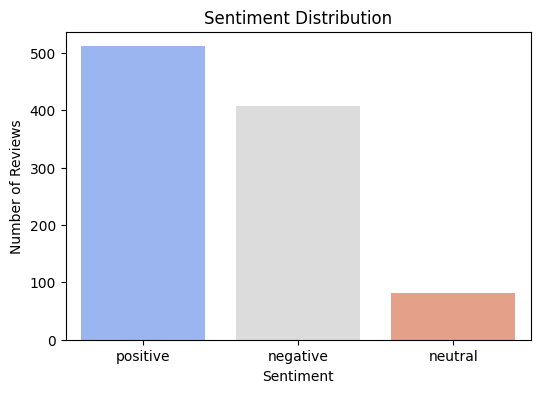

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

### Word Clouds for Positive & Negative Reviews

Visualize prominent terms in each sentiment group.

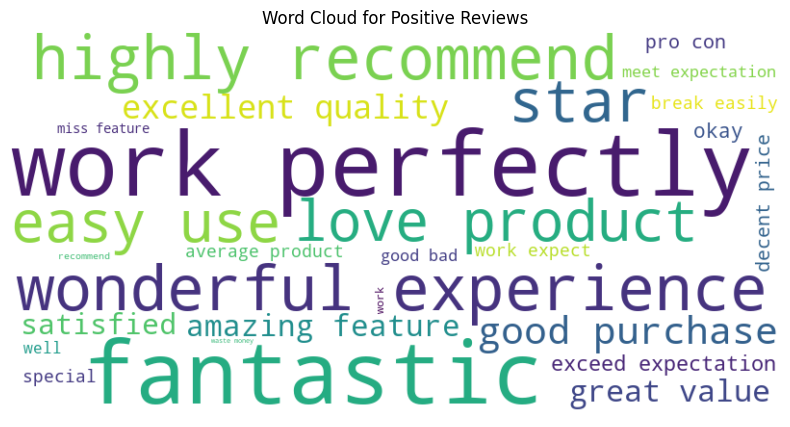

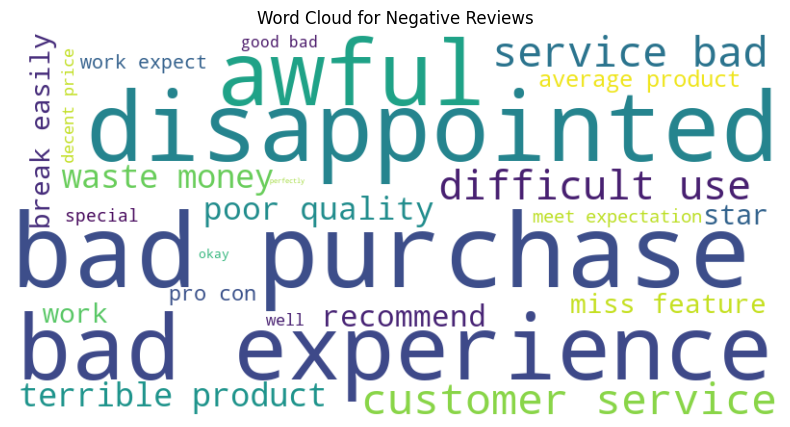

In [26]:
for sentiment in ['positive', 'negative']:
    text = ' '.join(df[df['Sentiment'] == sentiment]['CleanReviewText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Reviews')
    plt.show()

### Sentiment by Product

Analyze sentiment breakdown for each product.

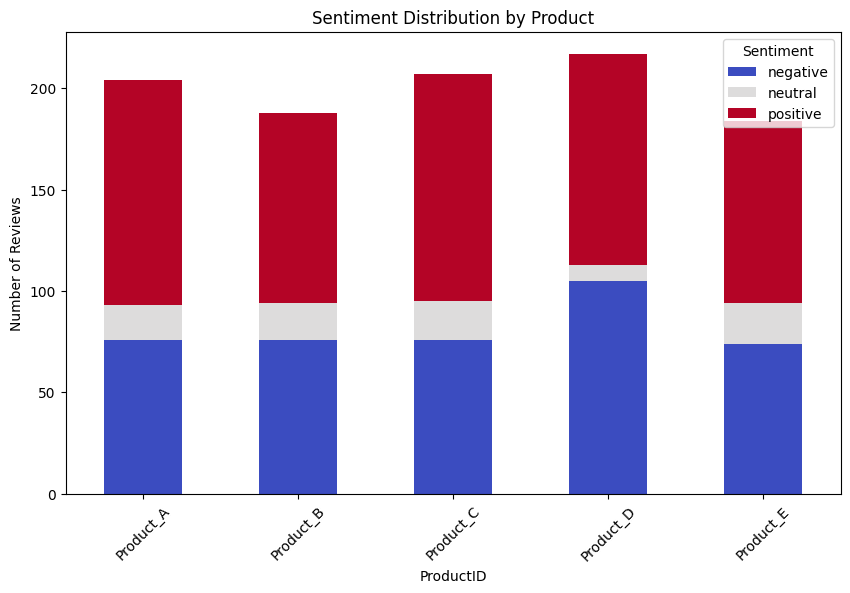

In [27]:
sentiment_product = df.groupby(['ProductID', 'Sentiment']).size().unstack().fillna(0)
sentiment_product.plot(kind='bar', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.ylabel('Number of Reviews')
plt.title('Sentiment Distribution by Product')
plt.xticks(rotation=45)
plt.show()

### Sentiment Trends Over Time

If review dates are available, show how sentiment changes over time.

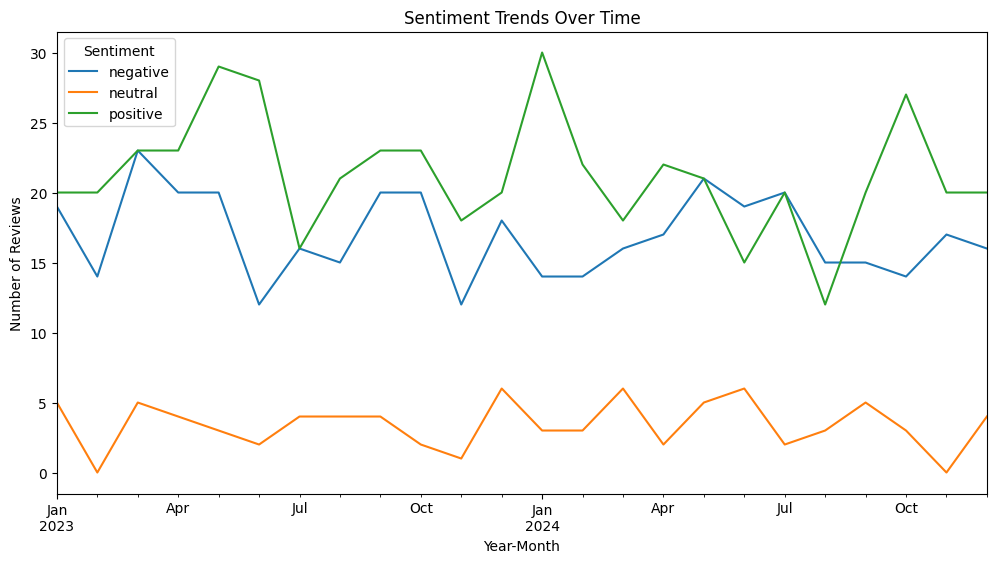

In [28]:
df['ReviewDate'] = pd.to_datetime(df['ReviewDate'])
df['YearMonth'] = df['ReviewDate'].dt.to_period('M')
sentiment_time = df.groupby(['YearMonth', 'Sentiment']).size().unstack().fillna(0)
sentiment_time.plot(kind='line', figsize=(12,6))
plt.title('Sentiment Trends Over Time')
plt.ylabel('Number of Reviews')
plt.xlabel('Year-Month')
plt.show()

## 5. Topic Modeling in Negative Reviews (LDA)

Use LDA to extract common complaint topics from negative reviews.

In [31]:
# Filter only negative reviews
neg_reviews = df[df['Sentiment'] == 'negative']
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(neg_reviews['CleanReviewText'])

# Fit LDA (5 topics)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display top words per topic
def display_topics(model, feature_names, no_top_words=8):
    for ix, topic in enumerate(model.components_):
        print(f"Topic {ix+1}: ", " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out())

Topic 1:  customer service bad recommend experience star pro good
Topic 2:  bad purchase experience break easily work star expect
Topic 3:  disappointed recommend money waste price decent special star
Topic 4:  product terrible waste money average feature miss work
Topic 5:  awful difficult use poor quality miss feature recommend


## 6. Key Findings and Recommendations

Summarize insights for product improvement and marketing.

In [30]:
total = len(df)
pos = (df['Sentiment']=='positive').sum()
neg = (df['Sentiment']=='negative').sum()
neu = (df['Sentiment']=='neutral').sum()
print(f"Sentiment Breakdown: {pos/total:.1%} positive, {neg/total:.1%} negative, {neu/total:.1%} neutral\n")

print('Common positive feedback:')
print(df[df['Sentiment']=='positive']['CleanReviewText'].sample(10, random_state=42).to_list())
print('\nCommon pain points:')
print(df[df['Sentiment']=='negative']['CleanReviewText'].sample(10, random_state=42).to_list())

Sentiment Breakdown: 51.1% positive, 40.7% negative, 8.2% neutral

Common positive feedback:
['fantastic exceed expectation', 'work break easily', 'great value easy use average product', 'wonderful experience fantastic average product', 'fantastic excellent quality', 'easy use work perfectly', 'highly recommend amazing feature', 'love product work perfectly', 'work perfectly highly recommend', 'easy use fantastic']

Common pain points:
['disappointed bad purchase', 'awful disappointed', 'break easily awful meet expectation', 'waste money awful special', 'disappointed bad purchase', 'break easily difficult use', 'bad purchase waste money well', 'bad purchase work', 'average product terrible product', 'disappointed recommend']


### Actionable Recommendations

- Emphasize positive aspects such as 'easy to use', 'excellent quality', and 'great value' in marketing material.
- Address pain points such as 'broke easily', 'customer service', and 'missing features' in product development and support.
- Use top negative review topics to guide product updates and support documentation.

---
You can further expand this notebook for more advanced analytics or reporting.